In [ ]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

from google.colab import files, output, drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

In [ ]:
import os
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

In [ ]:
df_cust = pd.read_csv('agg_customers.csv', sep=',',
                      index_col='customer_unique_id',
                      encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

In [ ]:
# Data selection
sel_cols_A = ['mean_prod_descr_length', 'mean_prod_wei_g', 'mean_prod_vol_cm3',
              'mean_ship_delay', 'avg_freight_payval_ratio', 'nb_not_rec_orders',
              'tot_comment_length','mean_rev_score', 'time_since_last_purch',
              'tot_price', 'mean_nb_items_per_ord', 'tot_nb_deliv_ord',
              'mean_pay_install']
dfA = df_cust[sel_cols_A]

In [ ]:
from umap import UMAP

def select_transform(df, sel_col, strat_quant='stand', UMAP_transf=False):

    ### Data to use for clusters analysis (untransformed)
    df_orig = df.copy('deep')
    # Data selection
    df_orig = df[sel_col]

    ### Data to use with clustering algorithms
    # Transformation prior to UMAP
    ct = CustTransformer(strat_quant=strat_quant)
    df_trans = ct.fit_transform(df_orig)   

    if UMAP_transf:
        # UMAP (same nb of components as nb of column in original dataset)
        n_comp = len(sel_col)
        umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1,
                    init='spectral', random_state=14)
        df_trans = pd.DataFrame(umap.fit_transform(df_trans),
                                index=df_trans.index,
                                columns=['UMAP'+str(i) for\
                                         i in range(n_comp)])

    return df_trans, df_orig

In [ ]:
%%time
dfA_trans, dfA = select_transform(df_cust, sel_cols_A,
                                  strat_quant='stand', UMAP_transf=True)

CPU times: user 5min 9s, sys: 7.03 s, total: 5min 16s
Wall time: 4min 45s


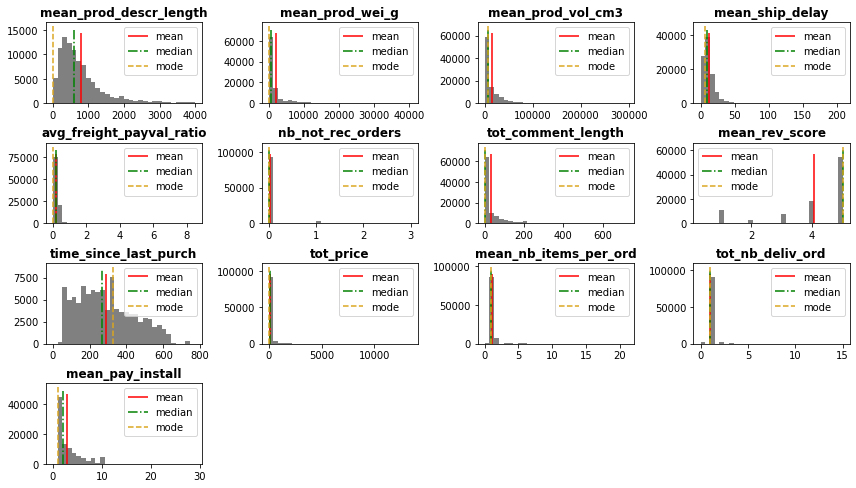

In [ ]:
# Histograms of the untransformed data
plot_histograms(df=dfA, cols=dfA.columns,
                figsize=(12,15), bins=30, layout=(9,4))

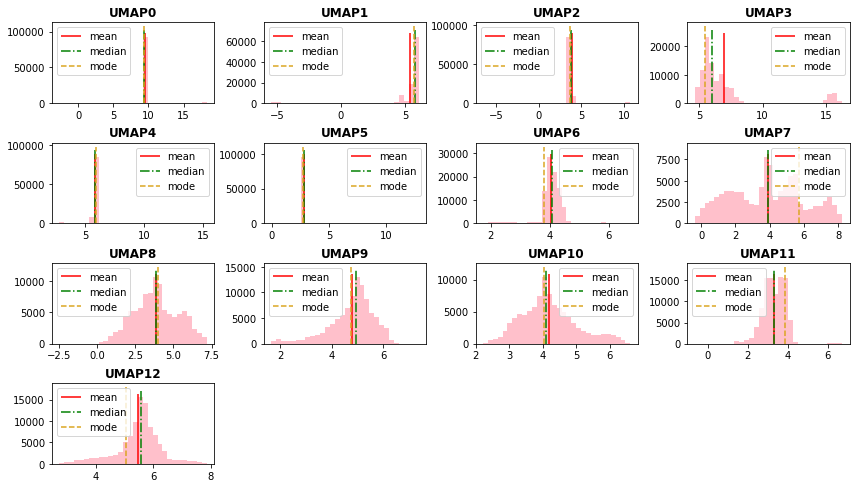

In [ ]:
# Histograms of the transformed data
plot_histograms(df=dfA_trans, cols=dfA_trans.columns, color='pink',
                figsize=(12,15), bins=30, layout=(9,4))

In [ ]:
df = dfA_trans
df_expl = dfA

sampling

In [ ]:
from sklearn.model_selection import train_test_split

# Bining the mean review score column for further stratification (sampling)

bin_mean_review = pd.cut(df_cust['mean_rev_score'], [0,1,2,3,4,5])

df_sampl, _ = train_test_split(df, train_size=10000, stratify=bin_mean_review)
ind_sampl = df_sampl.index

In [ ]:
# Sampled data for the cluster algo
X = df.loc[ind_sampl]

# Data unseen by the clusterer 
X_new = df

# KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n_clust = 6

In [ ]:
km = KMeans(n_clusters=n_clust).fit(X_new)
ser_clust_km_fit_all = pd.Series(km.labels_,
                         index=X_new.index,
                         name='km_clust_fit_all')

km = KMeans(n_clusters=n_clust).fit(X)
ser_clust_km = pd.Series(km.labels_,
                         index=ind_sampl,
                         name='km_clust')

ser_clust_km_all = pd.Series(km.predict(X_new),
                         index=X_new.index,
                         name='km_clust_all')

# Hierarchical clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
%%time
        
ahc = AgglomerativeClustering(n_clusters=n_clust).fit(df.loc[ind_sampl])
ser_clust_ahc = pd.Series(ahc.labels_,
                          index=ind_sampl,
                          name='ahc_clust')

CPU times: user 5.1 s, sys: 156 ms, total: 5.26 s
Wall time: 5.25 s


In [ ]:
clf = RandomForestClassifier(random_state=14)
ind_clust = InductiveClusterer(ahc, clf).fit(X)

ser_clust_ahc_all = pd.Series(ind_clust.predict(X_new),
                              index=X_new.index,
                              name='ahc_clust_all')

# Gaussian Mixture

In [ ]:
from sklearn import mixture

# n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']

# fitted on all
gmm = mixture.GaussianMixture(n_components=n_clust,
                              covariance_type='spherical')
ser_clust_gmm_fit_all = pd.Series(gmm.fit_predict(X_new),
                          index=X_new.index,
                          name='gmm_clust')

# fitted on sample
gmm = mixture.GaussianMixture(n_components=n_clust,
                              covariance_type='spherical')
ser_clust_gmm = pd.Series(gmm.fit_predict(X),
                          index=X.index,
                          name='gmm_clust')

# prediction fitted on sample
ser_clust_gmm_all = pd.Series(gmm.predict(X_new),
                          index=X_new.index,
                          name='gmm_clust_all')

In [ ]:
ser_clust_km.shape, ser_clust_km_all.shape, ser_clust_ahc.shape, ser_clust_ahc_all.shape, ser_clust_gmm.shape, ser_clust_gmm_all.shape

((10000,), (96096,), (10000,), (96096,), (10000,), (96096,))

In [ ]:
from sklearn.metrics import adjusted_rand_score

#### comparaison un seul algo fitté sur tout ou sur un sample (10 000)

In [ ]:
# comparaison clustering km fitted on all, fitted on 10000 sample
adjusted_rand_score(ser_clust_km_fit_all, ser_clust_km_all)

0.9954634143093937

In [ ]:
# comparaison clustering gm fitted on all, fitted on 10000 sample
adjusted_rand_score(ser_clust_gmm_fit_all, ser_clust_gmm_all)

0.9906813695065892

#### comparaison des algos entre eux sur sample

In [ ]:
# comparaison clustering km, ahc
adjusted_rand_score(ser_clust_km, ser_clust_ahc)

0.8515071975548368

In [ ]:
# comparaison clustering km, gmm
adjusted_rand_score(ser_clust_km, ser_clust_gmm)

0.900922562617774

In [ ]:
# comparaison clustering gmm, ahc
adjusted_rand_score(ser_clust_gmm, ser_clust_ahc)

0.9117030827246319

#### comparaison des algos sur tout

In [ ]:
# comparaison clustering km, ahc
adjusted_rand_score(ser_clust_km_fit_all, ser_clust_ahc_all), adjusted_rand_score(ser_clust_km_all, ser_clust_ahc_all)

(0.8685454987853689, 0.8690450410769387)

In [ ]:
# comparaison clustering km, gmm
adjusted_rand_score(ser_clust_km_fit_all, ser_clust_gmm_fit_all), adjusted_rand_score(ser_clust_km_all, ser_clust_gmm_all)

(0.906839033383911, 0.9080268556918136)

In [ ]:
# comparaison clustering ahc, gmm
adjusted_rand_score(ser_clust_ahc_all, ser_clust_gmm_fit_all), adjusted_rand_score(ser_clust_ahc_all, ser_clust_gmm_all)

(0.9203077296732717, 0.9215472966918626)

#### Visualisation of the best clusters

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silh = silhouette_score(X=X, labels=ser_clust_km)
dav_bould = davies_bouldin_score(X=X, labels=ser_clust_km)
cal_harab = calinski_harabasz_score(X=X, labels=ser_clust_km)
distor = km.inertia_
silh, cal_harab, dav_bould, distor

(0.44554654, 6333.111228510221, 0.7689698285891549, 56850.05217204774)

In [ ]:
silh = silhouette_score(X=X, labels=ser_clust_ahc)
dav_bould = davies_bouldin_score(X=X, labels=ser_clust_ahc)
cal_harab = calinski_harabasz_score(X=X, labels=ser_clust_ahc)
silh, cal_harab, dav_bould

(0.428773, 6180.991127920667, 0.8440387569723343)

In [ ]:
silh = silhouette_score(X=X, labels=ser_clust_gmm)
dav_bould = davies_bouldin_score(X=X, labels=ser_clust_gmm)
cal_harab = calinski_harabasz_score(X=X, labels=ser_clust_gmm)
silh, cal_harab, dav_bould

(0.43769154, 6272.868680384376, 0.8332596740178149)

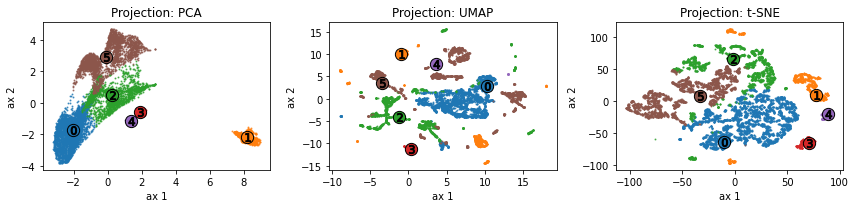

In [ ]:
# KMEANS

fig = plt.figure(figsize=(12,3))

tab_proj = ['PCA', 'UMAP', 't-SNE']
for i, proj in enumerate(tab_proj,1):
    ax = fig.add_subplot(1,len(tab_proj), i)
    plot_projection(X, model=km, proj=proj,
                    fig=fig, ax=ax)
fig.tight_layout()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: The ``n_components_`` attribute was deprecated in favor of ``n_connected_components_`` in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: The ``n_components_`` attribute was deprecated in favor of ``n_connected_components_`` in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: The ``n_components_`` attribute was deprecated in favor of ``n_connected_components_`` in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)


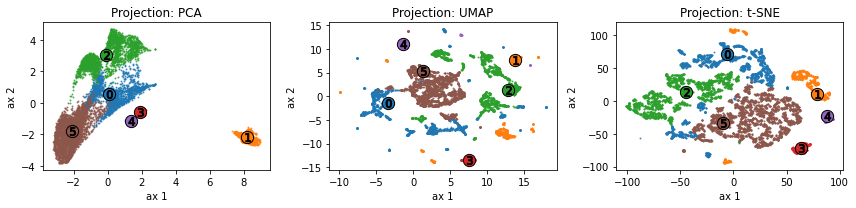

In [ ]:
# Hierarchical agglomerative

fig = plt.figure(figsize=(12,3))

tab_proj = ['PCA', 'UMAP', 't-SNE']
for i, proj in enumerate(tab_proj,1):
    ax = fig.add_subplot(1,len(tab_proj), i)
    plot_projection(X, model=ahc, proj=proj,
                    fig=fig, ax=ax)
fig.tight_layout()

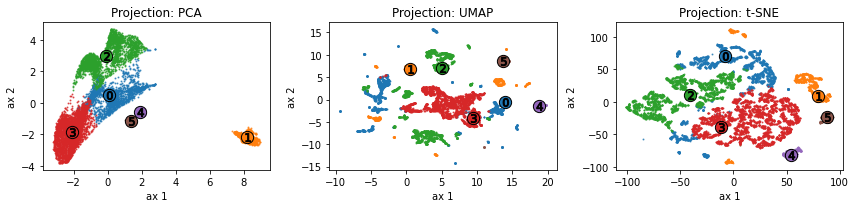

In [ ]:
# Gaussian Mixture

fig = plt.figure(figsize=(12,3))

tab_proj = ['PCA', 'UMAP', 't-SNE']
for i, proj in enumerate(tab_proj,1):
    ax = fig.add_subplot(1,len(tab_proj), i)
    plot_projection(X, model=gmm, proj=proj,
                    fig=fig, ax=ax)
fig.tight_layout()

In [ ]:

'''Computes the projection of the observations of df on the two first axes of
a transformation (PCA, UMAP or t-SNE)
The center option (clustering model needed) allows to project the centers
on the two axis for further display, and to return the fitted model
NB: if the model wa already fitted, does not refit.'''

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

def prepare_2D_axes(df, proj=['PCA', 'UMAP', 't-SNE'],
                    model=None, centers_on=False, random_state=14):

    dict_proj = dict()

    if centers_on:  # Compute and include the centers in the points
        model = model.fit(df) if not is_fitted(model) else model
        #### all clusterers don't have .cluster_centers method -> changed
        # centers = model.cluster_centers_ 
        # ind_centers = ["clust_" + str(i) for i in range(centers.shape[0])]
        # centers_df = pd.DataFrame(centers,
        #                           index=ind_centers,
        #                           columns=df.columns)
        #### all clusterers don't have .predict/labels_ method -> changed
        if hasattr(model, 'labels_'):
            clust = model.labels_
        else:
            clust = model.predict(df)
        centers_df = df.assign(clust=clust).groupby('clust').mean()

        df = df.append(centers_df)

    ## Projection of all the points through the transformations

    # PCA
    if 'PCA' in proj:
        pca = PCA(n_components=2, random_state=random_state)
        df_proj_PCA_2D = pd.DataFrame(pca.fit_transform(df),
                                      index=df.index,
                                      columns=['PC' + str(i) for i in range(2)])
        dict_proj = dict({'PCA': df_proj_PCA_2D})

    # UMAP
    if 'UMAP' in proj:
        umap = UMAP(n_components=2, random_state=random_state)
        df_proj_UMAP_2D = pd.DataFrame(umap.fit_transform(df),
                                       index=df.index,
                                       columns=['UMAP' + str(i) for i in range(2)])
        dict_proj = dict({'UMAP': df_proj_UMAP_2D})

    # t-SNE
    if 't-SNE' in proj:
        tsne = TSNE(n_components=2, random_state=random_state)
        df_proj_tSNE_2D = pd.DataFrame(tsne.fit_transform(df),
                                       index=df.index,
                                       columns=['t-SNE' + str(i) for i in range(2)])
        dict_proj = dict({'t-SNE': df_proj_tSNE_2D})

    # Separate the clusters centers from the other points if center option in on
    if centers_on:
        dict_proj_centers = {}
        for name, df_proj in dict_proj.items():
            dict_proj_centers[name] = dict_proj[name].loc[centers_df.index]
            dict_proj[name] = dict_proj[name].drop(index=centers_df.index)
        return dict_proj, dict_proj_centers, model
    else:
        return dict_proj


''' Plots the points on two axis (projection choice available : PCA, UMAP, t-SNE)
with clusters coloring if model available (grey if no model given).
NB: if the model wa already fitted, does not refit.'''


def plot_projection(df, model=None, proj='PCA', title=None,
                    figsize=(5, 3), palette='tab10', fig=None, ax=None, random_state=14):

    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax

    # if model : computes clusters, clusters centers and plot with colors
    if not model is None:

        # Computes the axes for projection with centers
        # (uses fitted model if already fitted)
        dict_proj, dict_proj_centers, model = prepare_2D_axes(df,
                                                              proj=[proj],
                                                              model=model,
                                                              centers_on=True,
                                                              random_state=random_state)
        # ...using model already fitted in prepare_2D_axes
        #### all clusterers don't have .predict/labels_ method -> changed
        if hasattr(model, 'labels_'):
            clust = model.labels_
        else:
            clust = model.predict(df)
        ser_clust = pd.Series(clust,
                              index=df.index,
                              name='Clust')

        n_clust = ser_clust.nunique()
        colors = sns.color_palette(palette, n_clust).as_hex()

        # Showing the points, cluster by cluster
        for i in range(n_clust):
            ind = ser_clust[ser_clust == i].index
            ax.scatter(dict_proj[proj].loc[ind].iloc[:, 0],
                       dict_proj[proj].loc[ind].iloc[:, 1],
                       s=1, alpha=0.7, c=colors[i])

            # Showing the clusters centers
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].values[i],
                       dict_proj_centers[proj].iloc[:, 1].values[i],
                       marker='o', c=colors[i], alpha=1, s=150, edgecolor='k')
            # Showing the clusters centers labels
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].values[i],
                       dict_proj_centers[proj].iloc[:, 1].values[i],
                       marker=r"$ {} $".format(str(i)),
                       c='k', alpha=1, s=70, )

    # if no model, only plot points in grey
    else:
        # Computes the axes for projection without centers
        dict_proj = prepare_2D_axes(df,
                                    proj=[proj],
                                    centers_on=False,
                                    random_state=random_state)
        # Plotting the point in grey
        ax.scatter(dict_proj[proj].iloc[:, 0],
                   dict_proj[proj].iloc[:, 1],
                   s=1, alpha=0.7, c='grey')

    title = "Projection: " + proj if title is None else title
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('ax 1'), ax.set_ylabel('ax 2')